WELCOME TO THE DEMO!!!

Let's get going!  We are going to assume you are using our custom datasets for this.  We used a Google Drive to store the data.  The following code supports the use of a Google Drive and code execution on Google Colab.

What do I need right now?
1.  A Google account
2.  Access to you own Google Drive

Once that is taken care of, head over to the Data section and copy our datasets to your Google Drive.  You will need these 3 sets: 
1. original_data_set   (these are the 3000 spectrogram images converted directly from the free-spoken-digit dataset)
2. plusAugmented       (these are the originals PLUS all of our custom spectrograms crafted from our own augmented audio files for a total of 32,898 images)
3.  unssen_originals   (102 original unaltered spectrogram images NOT included in the plusAugmented batch)

Go grab yourself a snack.  This will take a minute (or 12...or 20).


Next step, head over to Google Colab  (https://colab.research.google.com/).
You need to mount your Google Drive so you can have access to the datasets.
Execute the cell below to get started.

In [ ]:
 #this code snippet is02 used to import our custom dataset
from google.colab import drive
drive.mount('/content/drive')

Now we are cooking with grease!

The following section of code will import all the needed modules used to build our neural network.

If you get an error related to modules not being present, please refer here on how to install them locally:
https://docs.python.org/3/installing/index.html

In [2]:
# import all necessary modules
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline

Next step we need to set up the variables we used in the model.

We processed the images as 256 X 256.  You can change these settings if you like to make the picture smaller ( like 128 X 128) or larger (512 X 512). Smaller settings will process faster, but less detail means less accuracy.  The opposite would be the case for larger.

Be sure to use 3 for rgb (red blue green) setting to designate the images are in color.

Next up, figure out your batch size (how many images you want to process at a time) and the number or epochs (how many times you want to process the batch).  These are totally adjustable.  Careful though, there can be too much of a good thing.  We found that a batch size of 10 and 50 epochs would yield some decent results.

In [3]:
# set the variables to work with throughout model
img_height = 256
img_width= 256
rgb = 3
batch_size = 10  
epochs = 50

Alright, so it's time to get the data loaded.  Be sure to use your local path to the data.  Also be sure that you are placing the correct path into the proper identifier (originals to ods_trian for example).

In [4]:
# set-up training data from the original dataset only
ods_train = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/original_data_set', # need local path to directory
    labels = 'inferred',
    label_mode = 'categorical',
    batch_size = batch_size,
    image_size = (img_height, img_width),
    shuffle = True,
    seed = 123,
    validation_split = 0.3,
    subset = 'training',
)

Found 3000 files belonging to 10 classes.
Using 2100 files for training.


In [5]:
# set-up training data using original plus the augmented data as well
plusAugmented_train = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/plusAugmented', # need local path to directory
    labels = 'inferred',
    label_mode = 'categorical',
    batch_size = batch_size,
    image_size = (img_height, img_width),
    shuffle = True,
    seed = 123,
    validation_split = 0.3,
    subset = 'training',
)

Found 32898 files belonging to 10 classes.
Using 23029 files for training.


In [6]:
# now create a batch to test ont the plusAugmented model with unseen original images
ods_test = tf.keras.preprocessing.image_dataset_from_directory(
   '/content/drive/MyDrive/original_data_set', # need local path to directory
    labels = 'inferred',
    label_mode = 'categorical',
    batch_size = batch_size,
    image_size = (img_height, img_width),
    shuffle = True,
    seed = 456,
    validation_split = 0.3,
    subset = "validation",
)

Found 3000 files belonging to 10 classes.
Using 900 files for validation.


In [7]:
# also need a batch to test with from the original plus augmented dataset
plusAugmented_test = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/plusAugmented', # need local path to directory
    labels = 'inferred',
    label_mode = 'categorical',
    batch_size = batch_size,
    image_size = (img_height, img_width),
    shuffle = True,
    seed = 456,
    validation_split = 0.3,
    subset = "validation",
)

Found 32898 files belonging to 10 classes.
Using 9869 files for validation.


In [8]:
# the real test....
# NOW, a batch of unseen originals the plusAugmented model has not seen
unseen_test = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/unseen_originals', # need local path to directory
    labels = 'inferred',
    label_mode = 'categorical',
    batch_size = batch_size,
    image_size = (img_height, img_width),
    shuffle = True,
    seed = 456,
)

Found 102 files belonging to 10 classes.


You may have noticed that last batch we made does not have a validaiton split included.  That's because the unseen_test batch is strictly to test the trained model made from the plusAugmented dataset.  A split is not necessary.

Now it's time to make the doughnuts!

The following cell will build the model.  If you have an interest, you can twist and tweak quite a few variables here to alter how the model will perform.  For starters, I would suggest you use it as-is since this was the exact set-up used to get our final results.  You can always come back and customize it and try out something new a little later.

In [9]:
#  build up model
model = keras.models.Sequential()
model.add(keras.layers.Convolution2D(16, kernel_size = (5, 5), input_shape=(img_height, img_width, rgb ), activation='relu'))
model.add(keras.layers.Convolution2D(16, kernel_size = (3, 3), activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Dropout(0.2))
# have to make sure we pass the correct shape to LSTM
# use reshape to convert from 2D to 3D!
model.add(keras.layers.Reshape((125, -1)))
# using TimeDistributed layer
# this makes sure the dense layer keeps track of the 
# temporal aspects of the data
model.add(keras.layers.TimeDistributed(layers.Dense(50)))
model.add(keras.layers.LSTM(50, return_sequences=False))
model.add(keras.layers.Dense(10,activation = 'softmax'))

This next step is not 100% needed, but does give a really nice visual on the model structure.  It will display each layer's input and output.  This will give you an idea of how each layer connects moving downstream.

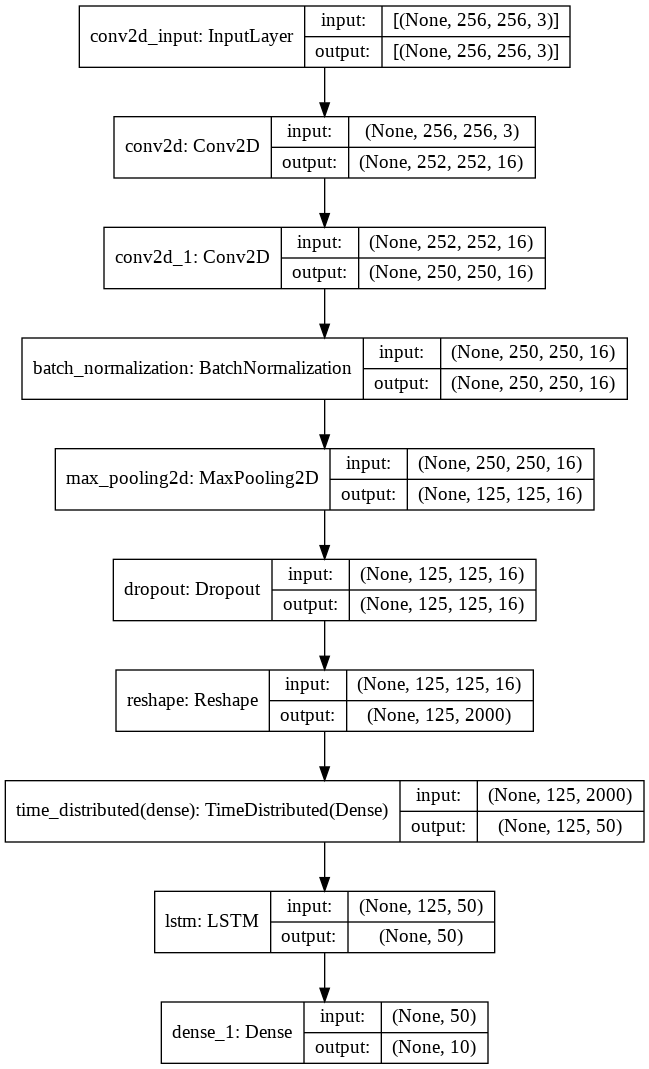

In [10]:
# display model layers w/ input and output from layers
tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=True)

We now have parameters in place, data initialized and split-up, and a model woven together.  Time to compile the model and get it ready to process.

In [11]:
# compile model   
model.compile(optimizer = keras.optimizers.Adam(),
             loss = [ keras.losses.CategoricalCrossentropy(from_logits=True)],
             metrics = [ keras.metrics.CategoricalAccuracy()])

The next step is not a requirement either, but again, this gives some insight into what is happening with the model.  A quick snapshot of each layer and how many parameters it will be working with summarized at the end.  Now, don't let the low number of total parameters at the end fool you.  This thing is going to take up a fair amount of time run (unless you are using some serious GPU horsepower).

In [12]:
# show a summary of layers and the parameters
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 252, 252, 16)      1216      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 250, 250, 16)      2320      
_________________________________________________________________
batch_normalization (BatchNo (None, 250, 250, 16)      64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 125, 125, 16)      0         
_________________________________________________________________
dropout (Dropout)            (None, 125, 125, 16)      0         
_________________________________________________________________
reshape (Reshape)            (None, 125, 2000)         0         
_________________________________________________________________
time_distributed (TimeDistri (None, 125, 50)           1

I guess it's time to make the magic happen...Let the training begin!!

In [13]:
# training the original dataset
ods_history = model.fit(ods_train,
                    batch_size = batch_size,
                    epochs = epochs,
                    verbose = 1)

Epoch 1/50
210/210 [==============================] - 16s 58ms/step - loss: 2.2997 - categorical_accuracy: 0.1378
Epoch 2/50
210/210 [==============================] - 12s 56ms/step - loss: 2.1576 - categorical_accuracy: 0.2259
Epoch 3/50
210/210 [==============================] - 12s 56ms/step - loss: 1.9966 - categorical_accuracy: 0.2821
Epoch 4/50
210/210 [==============================] - 12s 57ms/step - loss: 1.8287 - categorical_accuracy: 0.3530
Epoch 5/50
210/210 [==============================] - 12s 57ms/step - loss: 1.7162 - categorical_accuracy: 0.3992
Epoch 6/50
210/210 [==============================] - 12s 56ms/step - loss: 1.5575 - categorical_accuracy: 0.4567
Epoch 7/50
210/210 [==============================] - 12s 56ms/step - loss: 1.4317 - categorical_accuracy: 0.5009
Epoch 8/50
210/210 [==============================] - 12s 55ms/step - loss: 1.3621 - categorical_accuracy: 0.5321
Epoch 9/50
210/210 [==============================] - 12s 58ms/step - loss: 1.3582 - cat

The next cell gives us a little info on what just happened.  It will show you how well the training went.

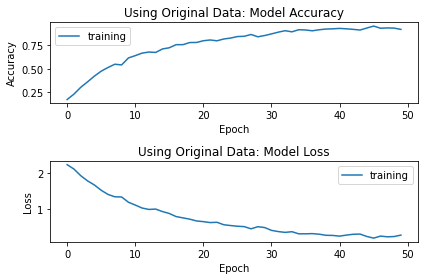

In [14]:
# how did we do?
# graphically display results of training
plt.figure()
plt.subplot(211)
plt.plot(ods_history.history['categorical_accuracy'])
plt.title('Using Original Data: Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['training'], loc = 'upper left')

plt.subplot(212)
plt.plot(ods_history.history['loss'])
plt.title('Using Original Data: Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training'], loc = 'upper right')

plt.tight_layout()
plt.show()

Cool little feature here.  You don't have to do this, but if you would like to be able to access these results for future use this will save your model after training.  

In [15]:
# go ahead and save the model here
model.save("ods_16.h5") # you can pick your own filename, just be sure to put .h5 at the end

One step closer to the end.

The model has been trained.  Let's check and validate that training.  The next cell uses the unseen chunk of images pulled off for validation.  We will be able to see how accurate our model really is.

In [16]:
# now test the model against the reserved unseen images from the original dataset
ods_t = model.evaluate(ods_test, verbose = 1)
print("Using only original test samples:")
print("Accuracy: ", ods_t[1] * 100)
print("Loss: ", ods_t[0])

90/90 [==============================] - 5s 44ms/step - loss: 0.9950 - categorical_accuracy: 0.7089
Using only original test samples:
Accuracy:  70.88888883590698
Loss:  0.9950082898139954


Now repeat the training and testing process for the plusAugmented data set.  Just a reminder, this one is ten times larger than the original.  Once you get it up and running, consider turning on the TV and catching a show.  May I suggest a Star Wars movie...possibly a few of them (just kidding).  Just something to pass the time due to the volume of data to process.

In [17]:
# next, we need to train with the original plus the augmented data on the exact same architecture
plusAugmented_history = model.fit(plusAugmented_train,
                    batch_size = batch_size,
                    epochs = epochs,
                    verbose = 1)

Epoch 1/50
2303/2303 [==============================] - 140s 61ms/step - loss: 1.1516 - categorical_accuracy: 0.6423
Epoch 2/50
2303/2303 [==============================] - 142s 61ms/step - loss: 0.7695 - categorical_accuracy: 0.7550
Epoch 3/50
2303/2303 [==============================] - 140s 61ms/step - loss: 0.6213 - categorical_accuracy: 0.7996
Epoch 4/50
2303/2303 [==============================] - 142s 61ms/step - loss: 0.5417 - categorical_accuracy: 0.8251
Epoch 5/50
2303/2303 [==============================] - 138s 60ms/step - loss: 0.4595 - categorical_accuracy: 0.8500
Epoch 6/50
2303/2303 [==============================] - 141s 61ms/step - loss: 0.4307 - categorical_accuracy: 0.8574
Epoch 7/50
2303/2303 [==============================] - 139s 60ms/step - loss: 0.4312 - categorical_accuracy: 0.8619
Epoch 8/50
2303/2303 [==============================] - 141s 61ms/step - loss: 0.3700 - categorical_accuracy: 0.8809
Epoch 9/50
2303/2303 [==============================] - 141s 61m

In [18]:
# save one last time
model.save("pA_16.h5")

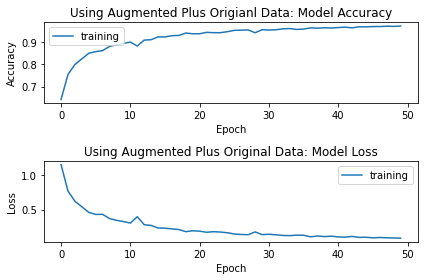

In [19]:
# how did we do?
# graphically display results of training
plt.figure()
plt.subplot(211)
plt.plot(plusAugmented_history.history['categorical_accuracy'])
plt.title('Using Augmented Plus Origianl Data: Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['training'], loc = 'upper left')

plt.subplot(212)
plt.plot(plusAugmented_history.history['loss'])
plt.title('Using Augmented Plus Original Data: Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training'], loc = 'upper right')

plt.tight_layout()
plt.show()


In [20]:
# now let's test with unseen images from the augmented plus original dataset
plusAugmented_history_test = model.evaluate(plusAugmented_test, verbose = 1)
print("Using the augmented plus original test samples:")
print("Accuracy: ", plusAugmented_history_test[1] * 100)
print("Loss: ", plusAugmented_history_test[0])

987/987 [==============================] - 46s 46ms/step - loss: 0.1274 - categorical_accuracy: 0.9627
Using the augmented plus original test samples:
Accuracy:  96.271151304245
Loss:  0.12736131250858307


AND NOW.....what we have all been waiting for....
Has this really been worth it???

Let's check our last model against the unssen images and see how it stacks up against the validation from the original model.

In [21]:
# NOW, let's test the plusAugmented model with super secret unseen original images
unseen_test_history = model.evaluate(unseen_test, verbose = 1)
print("Using completely unseen originals only:")
print("Accuracy: ", unseen_test_history[1] * 100)
print("Loss: ", unseen_test_history[0])

11/11 [==============================] - 1s 18ms/step - loss: 0.0571 - categorical_accuracy: 0.9706
Using completely unseen originals only:
Accuracy:  97.0588207244873
Loss:  0.057077936828136444


And you are done!

How did it go?  Use the accuracy from the 'unseen_test_history' and compare it to the accuracy from the 'ods_t' to figure out what level of improvement you achieved.

One thing you may find is that every time you train up the models (even reusing the same data over and over) you can get different results.
During the course of our testing, our results showed varying degrees of improvement.

We hope you found this demo informative and enjoyable.